# Running MAGIC and PHATE on Immunometabolism dataset
**Author:** Scott Campit

# Summary
This notebook performs data imputation using MAGIC for single-cell COBRA analyses.

To visualize the results, we will use PHATE, which was also developed in the same lab.

In [1]:
#!pip install --user magic-impute
#!pip install --user phate
import magic
import phate
import scprep

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Read excel files
import xlrd
import openpyxl
from openpyxl import load_workbook

import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

c:\Users\Scott\Envs\Python\immune\Scripts\python.exe
3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]
sys.version_info(major=3, minor=8, micro=6, releaselevel='final', serial=0)


# 1. Import data
First, let's import the immunometabolism data. I saved the data as an excel file where each sheet is a different cell lineage. The rows correspond to individual genes. The columns correspond to different time points.

In [8]:
# ACLX
#datapath = r"C:\Users\scott\Data\scRNASeq\shea\celldf.xlsx"

# Dell
datapath = r"D:\Data\scRNASeq\shea\celldf_ensembl.xlsx"


wb = load_workbook(filename=datapath, read_only=True)
print(wb.sheetnames)

['Stromal', 'AlveolarMacrophages', 'Macrophages', 'Monocytes', 'Pneumocytes', 'Bcells', 'Granulocytes', 'Tcells', 'Dendritic', 'Neutrophils', 'NK', 'Endothelial', 'HSC']


# 2. Analyze Neutrophil data specifically
Let's write up some code to preprocess the dataset. We'll analyze the Neutrophil dataset first, because that's the main dataset of interest.

In [9]:
counts = pd.read_excel(datapath, 
                       sheet_name=wb.sheetnames[0])

In [10]:
print(counts)

          MGI.symbol      HGNC.symbol  NCBI.gene..formerly.Entrezgene..ID  \
0      0610010F05Rik         KIAA1841                             84542.0   
1      0610010K14Rik  RNASEK-C17orf49                                 NaN   
2      0610010K14Rik         C17orf49                            124944.0   
3      0610030E20Rik          C2orf68                            388969.0   
4      0610040J01Rik          C4orf19                             55286.0   
...              ...              ...                                 ...   
13939           Zxdc             ZXDC                             79364.0   
13940         Zyg11b           ZYG11B                             79699.0   
13941            Zyx              ZYX                              7791.0   
13942          Zzef1            ZZEF1                             23140.0   
13943           Zzz3             ZZZ3                             26009.0   

        Gene.stable.ID  Stromal Cells  0  Stromal Cells  0.1  \
0      ENSG

First, let's grab the metadata we need.

In [11]:
# Drop symbols
ids = counts["Gene.stable.ID"]
counts = counts.drop(['MGI.symbol', 
                      'HGNC.symbol', 
                      'NCBI.gene..formerly.Entrezgene..ID', \
                      'Gene.stable.ID',
                      'Ensembl'], axis=1)

# Grab cell names
celltype = counts.columns

Then let's print the resulting dataframe.

In [12]:
print(counts.head())

   Stromal Cells  0  Stromal Cells  0.1  Stromal Cells  0.2  \
0                 0                   0                   0   
1                 0                   0                   0   
2                 0                   0                   0   
3                 0                   0                   0   
4                 0                   0                   0   

   Stromal Cells  0.3  Stromal Cells  0.4  Stromal Cells  0.5  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   Stromal Cells  0.6  Stromal Cells  0.7  Stromal Cells  0.8  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0              

The data is current arranged where the rows are genes and the columns are cell lines. Let's transpose the matrix so that columns are genes and rows are cell lines.

In [13]:
counts = counts.transpose()
counts = counts.reset_index()
counts = counts.drop('index', axis=1)

Set the columns to be gene symbols

In [14]:
counts.columns = ids
counts.index = celltype
print(counts.head())

Gene.stable.ID      ENSG00000162929  ENSG00000161939  ENSG00000258315  \
Stromal Cells  0                  0                0                0   
Stromal Cells  0.1                0                0                0   
Stromal Cells  0.2                0                0                0   
Stromal Cells  0.3                0                0                0   
Stromal Cells  0.4                0                0                0   

Gene.stable.ID      ENSG00000168887  ENSG00000154274  ENSG00000248713  \
Stromal Cells  0                  0                0                0   
Stromal Cells  0.1                0                0                0   
Stromal Cells  0.2                0                0                0   
Stromal Cells  0.3                0                0                0   
Stromal Cells  0.4                0                0                0   

Gene.stable.ID      ENSG00000110696  ENSG00000171159  ENSG00000197620  \
Stromal Cells  0                  0              

# 2. Data Preprocessing on a Single Cell Lineage
Let's now perform some data filtering.

## 2a. Filtering by library size
The library size of a cell is the number of unique mRNA molecules in the cell. As an arbitrary threshold, we will remove all cells that have fewer than 500 reads per cell.

<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

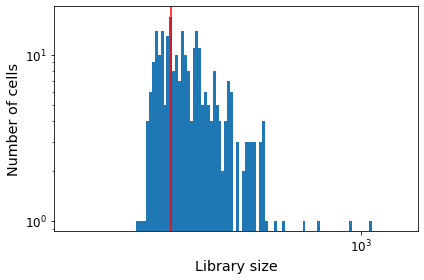

In [16]:
scprep.plot.plot_library_size(data=counts,
                              cutoff=250)

<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

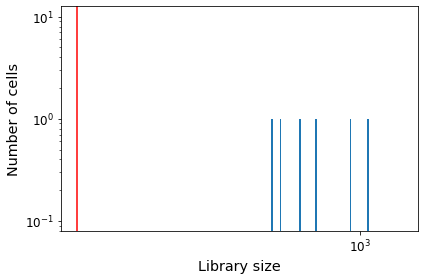

In [18]:
# be sure to uncomment this, unless your data is pre-filtered
counts = scprep.filter.filter_library_size(counts, cutoff=250)
scprep.plot.plot_library_size(data=counts,
                              cutoff=250)

## 2b. Filtering lowly expressed genes
Now let's filter lowly expressed genes. First, we'll get a count of the number of genes that are expressed in each cell.

In [40]:
genes_per_cell = np.sum(counts > 0, axis=0)

Then, let's visualize the data. There are several genes showing very little expression. We'll remove rarely-expressed genes.

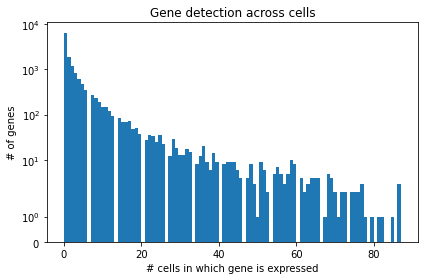

In [41]:
fig, ax = plt.subplots(1, figsize=(6,4))
ax.hist(genes_per_cell, bins=100)
ax.set_xlabel('# cells in which gene is expressed')
ax.set_ylabel('# of genes')
ax.set_yscale('symlog')
ax.set_title('Gene detection across cells')
fig.tight_layout()

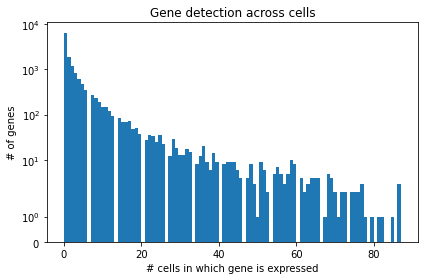

In [42]:
counts = scprep.filter.remove_rare_genes(counts, cutoff=0, min_cells=5)
fig, ax = plt.subplots(1, figsize=(6,4))
ax.hist(genes_per_cell, bins=100)
ax.set_xlabel('# cells in which gene is expressed')
ax.set_ylabel('# of genes')
ax.set_yscale('symlog')
ax.set_title('Gene detection across cells')
fig.tight_layout()

## 2c. Data normalization
Now let's normalize the data. First, we'll normalize the data by library size.

In [43]:
counts = scprep.normalize.library_size_normalize(counts)

Then we'll transform the data using the square root.

<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

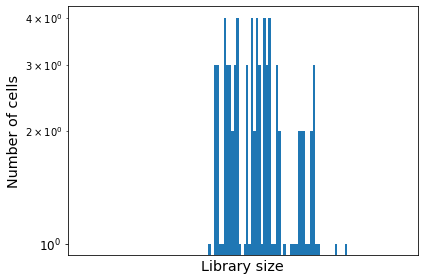

In [44]:
counts = scprep.transform.sqrt(counts)
scprep.plot.plot_library_size(data=counts)

# 3. Run MAGIC on a Single Cell Lineage
Now let's run MAGIC for data imputation with the normalized and filtered data.

In [45]:
magic_op = magic.MAGIC()
nk_magic = magic_op.fit_transform(counts, genes="all_genes")

Calculating MAGIC...
  Running MAGIC on 87 cells and 3366 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.07 seconds.
  Calculating imputation...
Calculated MAGIC in 0.09 seconds.


We can visualize the distribution of the imputed data.

<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

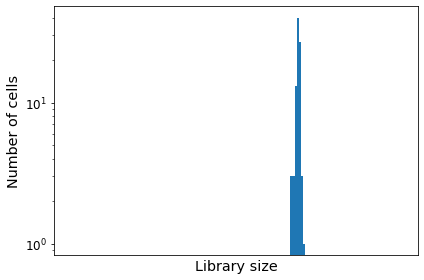

In [46]:
scprep.plot.plot_library_size(data=nk_magic)

In [47]:
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [48]:
nk_magic = nk_magic.round(decimals=4)
print(nk_magic)

Gene.stable.ID   ENSG00000162929  ENSG00000168887  ENSG00000110696  \
NK Cells  7               0.3195           0.4993           0.5420   
NK Cells  7.6             0.2886           0.3835           0.6272   
NK Cells  7.7             0.3057           0.4190           0.5363   
NK Cells  0.17            0.2816           0.3835           0.6561   
NK Cells  0.18            0.2826           0.3926           0.6130   
...                          ...              ...              ...   
NK Cells  14.17           0.2934           0.3988           0.5865   
NK Cells  14.19           0.3086           0.3950           0.5156   
NK Cells  14.20           0.2758           0.3973           0.6448   
NK Cells  14.21           0.2965           0.3934           0.5810   
NK Cells  14.22           0.2963           0.3796           0.6238   

Gene.stable.ID   ENSG00000171159  ENSG00000163807  ENSG00000112539  \
NK Cells  7               0.3378           0.3040           0.1871   
NK Cells  7.6      

Now let's make a heatmap of the data

In [49]:
#nk_magic.index = time
sns.histplot(data=pd.melt(nk_magic),
             bins=100)

NameError: name 'sns' is not defined

Now let's transform the normalized data into a robust Z-score and get a p-value out of it. We'll compute gene-wise Z-scores.

In [50]:
from scipy.stats import median_absolute_deviation as mad
mu = nk_magic.median(axis=0)
n = nk_magic.shape[1]
med_abs_dev = mad(nk_magic)
scale_factor = 1.4826
Z = (nk_magic - mu) / (med_abs_dev * scale_factor)
print(Z)

Gene.stable.ID   ENSG00000162929  ENSG00000168887  ENSG00000110696  \
NK Cells  7             1.016169         4.803608        -0.733164   
NK Cells  7.6          -0.297623        -0.361274         0.868518   
NK Cells  7.7           0.429427         1.222088        -0.840319   
NK Cells  0.17         -0.595246        -0.361274         1.411811   
NK Cells  0.18         -0.552728         0.044602         0.601571   
...                          ...              ...              ...   
NK Cells  14.17        -0.093539         0.321133         0.103395   
NK Cells  14.19         0.552728         0.151646        -1.229460   
NK Cells  14.20        -0.841847         0.254230         1.199381   
NK Cells  14.21         0.038266         0.080283         0.000000   
NK Cells  14.22         0.029762        -0.535221         0.804601   

Gene.stable.ID   ENSG00000171159  ENSG00000163807  ENSG00000112539  \
NK Cells  7             0.755592        -0.289872        -0.028434   
NK Cells  7.6      

Now let's plot the resulting distribution from taking the Z-score.

<AxesSubplot:ylabel='Count'>

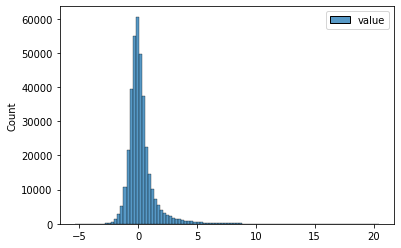

In [57]:
sns.histplot(data=pd.melt(Z),
             bins=100)

In [51]:
from scipy.stats import norm
pval = norm.sf(abs(Z))*2 
print(pval.shape)
sns.histplot(data=pval.flatten(),
             bins=100)


(87, 3366)


NameError: name 'sns' is not defined

In [66]:
pval = pd.DataFrame(pval,
                    index=nk_magic.index,
                    columns=nk_magic.columns)

# 4. Run PHATE
Now let's perform dimension reduction.

Calculating PHATE...
  Running PHATE on 106 observations and 3492 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.29 seconds.
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.30 seconds.
  Calculating optimal t...
    Automatically selected t = 12
  Calculated optimal t in 0.01 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.33 seconds.


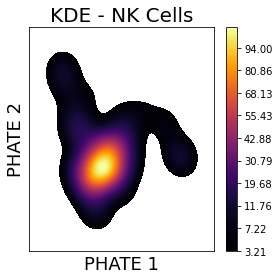

In [69]:
phate_op = phate.PHATE()
nk_phate = phate_op.fit_transform(nk_magic)

import seaborn as sns

fig, ax = plt.subplots(1, figsize=(4,4))
sns.kdeplot(nk_phate[:,0], 
            nk_phate[:,1], 
            n_levels=100, 
            shade=True, 
            cmap='inferno', 
            zorder=0, 
            ax=ax,
            cbar=True)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel('PHATE 1', fontsize=18)
ax.set_ylabel('PHATE 2', fontsize=18)

ax.set_title('KDE - NK Cells', fontsize=20)

fig.tight_layout()



# 4. Create a Function That Performs MAGIC Imputation for All Cell Types
Now that we have walked through the steps of a single lineage and found that the data distribution appears more "Normal", we can repeat this for all immune cell types. 

First, let's define a function to compute some robust standardized data using the robust Z-score method.

In [3]:
from scipy.stats import median_absolute_deviation as mad
from scipy.stats import norm

def robust_zscore(df):
    """
    robust_zscore computes a modified version of the Z-score centered around the media and scaled by the median absolute deviation.
    INPUT:
      :param df: A data frame corresponding to numerical values where rows correspond to cells and columns correspond to genes.
    OUTPUTS:
      :output Z: A data frame of the robust Z-scores.
      :output pval: A data frame of the p-values corresponding to the robust Z-scores.

    """
    # Compute model parameters
    mu = df.median(axis=0)
    n = df.shape[1]
    med_abs_dev = mad(df)
    scale_factor = 1.4826

    # Compute robust Z-score
    Z = (df - mu) / (med_abs_dev * scale_factor)

    # Compute P-value based on Z-score
    pval = norm.sf(abs(Z))*2 
    pval = pd.DataFrame(pval,
                    index=df.index,
                    columns=df.columns)
    return(Z, pval)

Next, we'll define a function that runs the MAGIC pipeline described above.

In [6]:
def MAGIC_pipeline(df):
    """
    MAGIC_pipeline performs data preprocessing, MAGIC imputation, and data standardization.
    INPUT: 
      :param df: A pandas dataframe of the raw counts data.
    OUTPUT:
      :param Z: A pandas dataframe of the Z-scores that reach a p-value threshold less than 0.05.
    """
    # Drop symbols
    ids = df["Gene.stable.ID"]
    df = df.drop(['MGI.symbol', 
                  'HGNC.symbol', 
                  'NCBI.gene..formerly.Entrezgene..ID', 
                  'Gene.stable.ID',
                  'Ensembl'], axis=1)

    # Grab cell names
    celltype = df.columns

    # Annotate and configure data
    df = df.transpose()
    df = df.reset_index()
    df = df.drop('index', axis=1)
    df.columns = ids
    df.index = celltype

    # Perform some data filtering
    df = scprep.filter.filter_library_size(df, cutoff=250)
    df = scprep.filter.remove_rare_genes(df, cutoff=0, min_cells=5)

    # Perform count normalization and square root transformation.
    df = scprep.normalize.library_size_normalize(df)
    df = scprep.transform.sqrt(df)

    # Data imputation with MAGIC
    magic_op = magic.MAGIC()
    magic_data = magic_op.fit_transform(df, genes="all_genes")
    magic_data = magic_data.round(decimals=4)

    # Compute Z-scores
    Z, pvalue = robust_zscore(magic_data)
    Z[pvalue > 0.05] = np.NaN

    return(Z)

Finally, let's iterate this pipeline across all cell types. I ended up having to delete the cache for memory intensive purposes. Also, ensure the virtual environment is using the 64 bit version of Python, otherwise you will run into memory issues.

In [7]:
for celltypes in wb.sheetnames: 
    counts = pd.read_excel(datapath, 
                        sheet_name=celltypes)
    Z = MAGIC_pipeline(counts)
    del counts

    # ACLX
    #Z.to_csv('C:/Users/scott/Analysis/Immune/'+celltypes+'_magic.csv')

    # Dell
    Z.to_csv('D:/Analysis/Immune/'+celltypes+'_magic.csv')

    del Z

Calculating MAGIC...
  Running MAGIC on 6 cells and 45 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 6, n_neighbors = 16